### Klaviyo Exercise
In order to remove bias, we have anonymized this step of the interview process. 

 * **Please do not deanonymize yourself in this jupyter notebook**.
 * **Please write your code and solutions in this notebook and return it to us when you are finished**.

### Interpreting the Orders Dataset

For questions 1, 2, and 3, you will work with sales data from a marketplace with several stores. The attached CSV, `screening_exercise_orders_v202102.csv`, lists the customer, date, and dollar value of orders placed in 2017. The gender of each customer is also provided. Please do not excluded $0 orders. 

### Exercise 1

Assemble a dataframe with one row per customer and the following columns:
* customer_id 
* gender
* most_recent_order_date 
* order_count (number of orders placed by this customer)

Sort the dataframe by customer_id ascending and display the first 10 rows.

In [23]:
import pandas as pd

panda = pd.read_csv(r'C:\Home Base\Misc\Jobs\Klaviyo\screening_exercise_orders_v202102.csv', 
                   usecols = ['customer_id', 'gender', 'date', 'value'],
                   header=0, parse_dates=['date']).sort_values(['customer_id', 'date']).reset_index(drop=True)
panda.columns = ['customer_id', 'gender', 'most_recent_order_date', 'order_count']

most_recent = panda.groupby('customer_id').last().reset_index(drop=True)

print(most_recent.head())

   gender most_recent_order_date  order_count
0       0    2017-01-01 00:11:31        198.5
1       0    2017-01-01 00:29:56        338.0
2       1    2017-02-19 21:35:31        176.0
3       1    2017-04-26 02:37:20        704.0
4       0    2017-01-01 03:11:54        508.0


### Exercise 2
Plot the count of orders per week (for all stores together). Do not use plotly, as plotly graphs in Jupyter Notebooks don't render correctly on different machines.

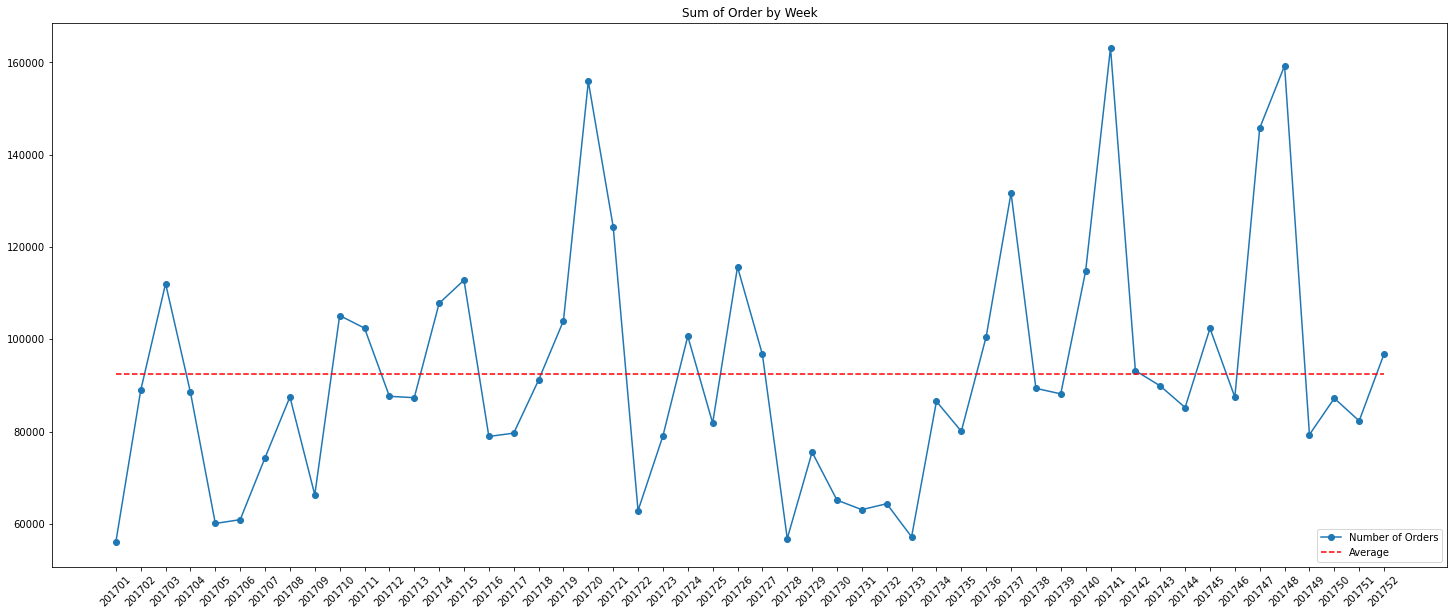

In [24]:
from matplotlib import pyplot as plt
import numpy as np

panda = panda.sort_values('most_recent_order_date')

# There is only 2017 data in here, so it doesn't matter, but this would let us track week-over-week for multiple years
# dt.week assigns the first day of the week to 52, so using day of year and ceiling instead
panda['order_week'] = (panda['most_recent_order_date'].dt.year*100 + np.ceil(panda['most_recent_order_date'].dt.dayofyear/7).astype(int)).astype(str)
panda['order_week'] = np.where(panda['order_week'] == '201753', '201752', panda['order_week'])

weekly_order = panda.groupby('order_week')['order_count'].sum()

plt.figure(figsize=(25, 10))
plt.xticks(rotation=45)
plt.plot(weekly_order.index, weekly_order, marker='o')
plt.plot(weekly_order.index, np.repeat(np.mean(weekly_order), len(weekly_order)), '--', color='red')
plt.title('Sum of Order by Week')
plt.legend(['Number of Orders', 'Average'], loc='lower right')

### Exercise 3

Compute the mean order value for gender 0 and for gender 1. Do you think the difference is significant? 

**Justify your choice of method and state any assumptions you make. Make sure you are clear about why your method is suitable for this dataset, in particular.**.

In [27]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns

#sns.displot(panda.groupby('customer_id').size().sort_values())

# Our biggest problem is that most hypothesis tests assume independence between rows and we know that will (probably)
# be violated in our case, because the same person customer can make multiple purchases, and those purchases will (probably)
# be correlated. So we need to insure conditional independence by controlling for that. Unfortunately, 65% of the customers
# are one time customers, so putting in that many dummy variables is likely computationally prohibitive. A random intercepts
# model should allow us to get around this. Unfortunately (again) statsmodels only has support for linear models with random intercepts
# models, and I'm not going way out of my way for this assignment to build one myself, so we are sacrificing the fact that
# we are incorrectly assuming normality. I think the benefit of controlling for multiple customers though, outweighs the cost
# of the normality assumption. We are also assuming that there are no other confounders, and a bunch of other things, but
# I don't want this to be an essay

#print(len(set(panda.customer_id))/len(panda))

model = smf.mixedlm('order_count ~ gender', panda, groups=panda['customer_id'])
results = model.fit()
print(results.summary())

# After controlling for the customer ID, the relationship is not significant at a 0.05 alpha level.


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: order_count
No. Observations: 13471   Method:             REML       
No. Groups:       8814    Scale:              99810.4272 
Min. group size:  1       Log-Likelihood:     -98949.8991
Max. group size:  25      Converged:          Yes        
Mean group size:  1.5                                    
---------------------------------------------------------
            Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   354.759    5.300 66.935 0.000 344.371 365.147
gender      -10.441    7.507 -1.391 0.164 -25.154   4.272
Group Var 48867.136    8.391                             



### Interpreting the Product Dataset
For this question you will work with the data in the CSV `screening_exercise_products_v202102.csv`. This dataset shows the number of times a particular item was sold. It contains the following columns: 
* number_of_orders - the number of orders containing the product
* store_id - the ID of the store selling the product
* product_id - the ID of the product itself
* is_red - whether the product is red.

### Exercise 4

Suppose some of our customers came to us with the belief that the color red generates more sales than other colors.  Based on this dataset, would you suggest that companies color more of their products red? Why or why not, and what other factors could be important to determine this? 

**Please justify your answer and state any assumptions you make.**

In [49]:
panda = pd.read_csv(r'C:\Home Base\Misc\Jobs\Klaviyo\screening_exercise_products_v202102.csv')

#print(panda.groupby('store_id').size())
#sns.histplot(panda.groupby('product_id').size())
#sns.histplot(panda.is_red)

print(len(panda.groupby('product_id'))/len(panda))
print(len(panda.groupby('store_id'))/len(panda))

# I am making essentially the same assumptions I made previously. There are lots of stores, lots of products,
# this violates the independence assumption and we want to get that back. Assuming there are no ommitted variables
# and no confounders, number of orders should be conditionally independent after controlling for this. 
# Number of orders isn't actually normally distributed, so a linear model isn't 100% appropriate, but the independence
# assumption is more important. So, I am going to use another random intercepts model. 

#panda['intercept'] = 1
#vcf = {'store_id': '0 + C(store_id)', 'product_id': '0 + C(product_id)'}

#model = smf.mixedlm('number_of_orders ~ is_red', panda, groups='intercept', vc_formula=vcf, re_formula='0')
#results = model.fit()
#print(results.summary())

# We're getting convergence warnings when I run both ID's as a random intercept. 
# Relatively speaking, there aren't that many stores, so doing that as a fixed effect could be sufficient

x = pd.merge(panda['is_red'].astype(int), pd.get_dummies(panda.store_id, prefix='store_id', drop_first=True), how='outer', left_index=True, right_index=True)
y = panda['number_of_orders']

model = sm.MixedLM(y, x, groups=panda['product_id'])
results = model.fit()
print(results.summary())

# After controlling for store and product, red products do seem to sell better than other products, so, all else equal, selling more red products could be good
# It's hard to say for sure without knowing more information. IE it could be the case that all red products are toys and all brown products are ladders
# and people by toys more frequently than they buy ladders. There could be any number of other explanations. But, based on this information,
# it looks like red products perform better. 


0.8493333333333334
0.009333333333333334
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: number_of_orders
No. Observations: 3000    Method:             REML            
No. Groups:       2548    Scale:              90.7330         
Min. group size:  1       Log-Likelihood:     -11267.5053     
Max. group size:  4       Converged:          Yes             
Mean group size:  1.2                                         
---------------------------------------------------------------
                Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
---------------------------------------------------------------
is_red           4.364     0.378  11.561  0.000   3.624   5.104
store_id_10     22.727     0.850  26.750  0.000  21.062  24.392
store_id_11     20.596     1.085  18.975  0.000  18.468  22.723
store_id_12     24.305     1.083  22.443  0.000  22.182  26.427
store_id_13     22.881     1.083  21.137  0.000  20.759  25.002
store_id_14     22.7

### Exercise 5

Describe one of your favorite tools or techniques and give a small example of how it has helped you solve a problem. Limit your answer to one short paragraph, and please be specific. 

In [ ]:
'''
My favorite tool/technique, probably by far, is the genetic algorithm. It's really paid off more me in terms of providing a grounded way to make decisions based on the data, having the flexibility to acheived 
whatever goal you want it to, and doing so in a relatively efficient manner (compared to other optimization techniques). To give a recent example, we were trying to build a model that predicts how likely we 
are to recover a vehicle after the account charges off. All we cared about was predictive accuracy, so my job was to find the a good, predictive model. In order to do this, I wrote a genetic algorithm that 
searched for the model that maximized cross-validated ROC AUC by simultaneously choosing between thousands of possible combinations of features, model types (e.g. logistic, vs. GBM vs. RF) and identified
a highly predictive model. Once found, the genetic algorithm made it easy to justify why I made that choice, easy to document how we came to that model, and easy to replicate the process in the future as needed.
'''